### Notebook 02: Baseline Models (Single-task)

This notebook covers the full preprocessing pipeline for baseline vision models for image classification using RestNet50.

This notebook trains two SEPARATE models:
  - Model A: Stance Classification (support/oppose)
  - Model B: Persuasiveness Classification (yes/no)

Images are resized, normalized and batched. Models are fine-tuned with cross-entropy loss and evaluated on our goal metric - F1-Score (Binary).

In [26]:
# Libraries
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm.auto import tqdm
from scipy.stats import pearsonr


# Random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Seed:  {SEED}")
print(f"Using device: {device}")

Seed:  42
Using device: cuda


In [27]:
#Paths
data_path = "../../data/"
img_path = "../../data/images"

train_path = os.path.join(data_path,"train.csv")
dev_path   = os.path.join(data_path,"dev.csv")
test_path  = os.path.join(data_path,"test.csv")

#Load Data
df_train = pd.read_csv(train_path)
df_dev   = pd.read_csv(dev_path)
df_test  = pd.read_csv(test_path)

# Map labels to ints
stance_2id = {"oppose": 0, "support": 1}
pers_2id = {"no": 0, "yes": 1}

for df in [df_train, df_dev, df_test]:
    df["label"] = df["stance"].map(stance_2id)
    df["persuasiveness_label"] = df["persuasiveness"].map(pers_2id)


print(f"\n Train label distribution:")
print(f"\n Stance: \n Oppose: {(df_train['label']==0).sum()}\n Support: {(df_train['label']==1).sum()}")
print(f"\n\n  Persuasiveness \n No: {(df_train['persuasiveness_label']==0).sum()}\n Yes: {(df_train['persuasiveness_label']==1).sum()}")



 Train label distribution:

 Stance: 
 Oppose: 1095
 Support: 719


  Persuasiveness 
 No: 1285
 Yes: 529


In [28]:
# Dataset class
class ImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, include_labels=True):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.include_labels = include_labels

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, str(row['tweet_id']) + ".jpg")

        # We add a try-except block to handle corrupted images
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"[WARNING] Skipping corrupted image: {img_path}")
            return self.__getitem__((idx + 1) % len(self.df))
            
        if self.transform:
            image = self.transform(image)
        
        if self.include_labels:
            stance = torch.tensor(row['label'], dtype=torch.long)
            pers = torch.tensor(row['persuasiveness_label'], dtype=torch.long)
            return {'image': image,'stance': stance,'persuasiveness': pers}
        else:
            return {'image': image}

In [29]:
#Load DataLoaders and Transforms
IMG_SIZE = 384  # Baseline size, can ajust later
BATCH_SIZE = 32
NUM_WORKERS = 1

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



train_dataset = ImageDataset(df_train, img_path, transform=transform)
dev_dataset   = ImageDataset(df_dev, img_path, transform=transform)
test_dataset  = ImageDataset(df_test, img_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,shuffle=True)
dev_loader   = DataLoader(dev_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,shuffle=True)

In [30]:
# Training hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 10 
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-4  
PATIENCE = 3

# Model
MODEL_NAME = "resnet50"
PRETRAINED = True
NUM_CLASSES = 2

print("Configuration:\n")
print(f"Model: {MODEL_NAME}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")

Configuration:

Model: resnet50
Number of classes: 2
Batch size: 32
Epochs: 10
Learning rate: 2e-05


In [31]:
# We see the architecture of our baseline model (Restnet50)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
print(model)

# Listar layers de forma plana con nombre
print("\n--- Named layers ---")
for name, module in model.named_modules():
    print(name, "->", module)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
class BaselineClassifier(nn.Module):    
    def __init__(self, num_classes=NUM_CLASSES, pretrained=True, model_name=MODEL_NAME):
        super(BaselineClassifier, self).__init__()
        
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)

        
        for name, param in self.backbone.named_parameters():
            if "layer4" not in name and "fc" not in name:
                param.requires_grad = False
        
        # Get the number of features from the original FC layer
        num_features = self.backbone.fc.in_features
        
        # Replace the final fully connected layer:  FC(2048 -> 2) for binary classification
        self.backbone.fc = nn.Linear(num_features, num_classes)
        
        print(f"Model initialized: {model_name}")
        print(f"Pretrained: {pretrained}")
        print(f"Num classes: {num_classes}")
        print(f"Feature dimension: {num_features}")
    
    def forward(self, x):
        return self.backbone(x)

# Test model initialization
test_model = BaselineClassifier(num_classes=2, pretrained=PRETRAINED, model_name=MODEL_NAME)
print(f"Model total parameters: {sum(p.numel() for p in test_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in test_model.parameters() if p.requires_grad):,}")
del test_model

Model initialized: resnet50
Pretrained: True
Num classes: 2
Feature dimension: 2048
Model total parameters: 23,512,130
Trainable parameters: 14,968,834


In [ ]:
# Training function for single-task model
def train_single_task_model(train_loader: DataLoader,dev_loader: DataLoader,target_task: str = 'stance', 
    num_epoch = NUM_EPOCHS,learning_rate=LEARNING_RATE,weight_decay=WEIGHT_DECAY,patience=PATIENCE,
    device: torch.device = device):
    
    print(f"Starting training for task: {target_task}")
    
    # Initialize model
    model = BaselineClassifier(num_classes=NUM_CLASSES,pretrained=PRETRAINED,model_name=MODEL_NAME).to(device)
    

    #We use CrossEntropyLoss for binary classification
    criterion = nn.CrossEntropyLoss()
    
    # Optimizer AdamW better than Adam for transformers
    optimizer = torch.optim.AdamW(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
    
    # Learning rate scheduler, we reduce it if we find a plateu
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.5,patience=2)
    
    # History tracking
    history = {
        'train_loss': [],
        'dev_f1': [],
        'dev_loss': [],
        'learning_rates': []
    }
    
    # Early stopping variables
    best_f1 = 0.0
    best_model_state = None
    epochs_without_improvement = 0
    
    # Training loop
    for epoch in range(num_epoch):
        print(f"\nEpoch {epoch + 1}/{num_epoch}")
        
        # TRAINING PHASE
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []
        
        pbar = tqdm(train_loader, desc="Training", leave=False)
        for batch in pbar:
            # Get images and labels
            images = batch['image'].to(device)
            
            # Select the target task label
            if target_task == 'stance':
                labels = batch['stance'].to(device)
            elif target_task == 'persuasiveness':
                labels = batch['persuasiveness'].to(device)
            else:
                raise ValueError(f"Unknown task: {target_task}")
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track metrics
            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        # Training metrics
        train_loss = train_loss / len(train_loader.dataset)
        train_f1 = f1_score(train_labels, train_preds, average='binary', pos_label=1)
        
        # VALIDATION PHASE
        model.eval()
        dev_loss = 0.0
        dev_preds = []
        dev_labels = []
        
        with torch.no_grad():
            for batch in tqdm(dev_loader, desc="Validation", leave=False):
                images = batch['image'].to(device)
                
                if target_task == 'stance':
                    labels = batch['stance'].to(device)
                elif target_task == 'persuasiveness':
                    labels = batch['persuasiveness'].to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Track metrics
                dev_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                dev_preds.extend(preds.cpu().numpy())
                dev_labels.extend(labels.cpu().numpy())
        
        # Calculate validation metrics
        dev_loss = dev_loss / len(dev_loader.dataset)
        dev_f1 = f1_score(dev_labels, dev_preds, average='binary', pos_label=1)
        
        # Update learning rate scheduler
        scheduler.step(dev_f1)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['dev_f1'].append(dev_f1)
        history['dev_loss'].append(dev_loss)
        history['learning_rates'].append(current_lr)
        
        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")
        print(f"Dev Loss: {dev_loss:.4f} | Dev F1: {dev_f1:.4f}")
        print(f"Learning Rate: {current_lr:.2e}")
        
        # Early stopping check
        if dev_f1 > best_f1:
            best_f1 = dev_f1
            best_model_state = model.state_dict().copy()
            epochs_without_improvement = 0
            print(f"New best F1: {best_f1:.4f}")
        else:
            epochs_without_improvement += 1
            print(f"No improvement for {epochs_without_improvement} epoch(s)")
            
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs")
                break
    
    # Load best model
    model.load_state_dict(best_model_state)
    print(f"Training complete! Best Dev F1: {best_f1:.4f}")
    
    return model, history

print("Training function defined")

Training function defined


In [34]:
# Evaluation function
def evaluate_model(model: nn.Module,data_loader: DataLoader,target_task: str = 'stance',
    device: torch.device = device):
   
    
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=f"Evaluating {target_task}", leave=False):
            images = batch['image'].to(device)
            
            if target_task == 'stance':
                labels = batch['stance'].to(device)
            elif target_task == 'persuasiveness':
                labels = batch['persuasiveness'].to(device)
            
            # Forward pass
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            # Collect predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary', pos_label=1, zero_division=0)
    recall = recall_score(all_labels, all_preds, average='binary', pos_label=1, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='binary', pos_label=1, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_true': np.array(all_labels),
        'y_pred': np.array(all_preds),
        'y_prob': np.array(all_probs)
    }

print("Evaluation function defined")

Evaluation function defined


###  Baseline A: Stance Classification (Support Vs Oppose)

In [35]:
# Train stance model
stance_model, stance_history = train_single_task_model(
    train_loader=train_loader,
    dev_loader=dev_loader,
    target_task='stance',
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE,
    device=device
)

# We evaluate on test set
print("Evaluating Stance Model on TEST set:")
stance_test_results = evaluate_model(stance_model, test_loader, target_task='stance', device=device)

print("\n Stance Model - Test Results: ")
print(f"Accuracy:  {stance_test_results['accuracy']:.4f}")
print(f"Precision: {stance_test_results['precision']:.4f}")
print(f"Recall:    {stance_test_results['recall']:.4f}")
print(f"F1 Score:  {stance_test_results['f1']:.4f}")


Starting training for task: stance
Model initialized: resnet50
Pretrained: True
Num classes: 2
Feature dimension: 2048

Epoch 1/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
Train Loss: 0.6786 | Train F1: 0.4710
Dev Loss: 0.6462 | Dev F1: 0.2273
Learning Rate: 2.00e-05
New best F1: 0.2273

Epoch 2/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
Train Loss: 0.6151 | Train F1: 0.3601
Dev Loss: 0.6108 | Dev F1: 0.3529
Learning Rate: 2.00e-05
New best F1: 0.3529

Epoch 3/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
Train Loss: 0.5500 | Train F1: 0.5762
Dev Loss: 0.5922 | Dev F1: 0.4715
Learning Rate: 2.00e-05
New best F1: 0.4715

Epoch 4/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg

AssertionError

: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/

[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
Train Loss: 0.4825 | Train F1: 0.7066
Dev Loss: 0.5995 | Dev F1: 0.4715
Learning Rate: 2.00e-05
No improvement for 1 epoch(s)

Epoch 5/10


Training:   0%|          | 0/57 [00:05<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
AssertionError  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
:     can only test a child processself._shutdown_workers()

  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg

if w.is_alive():


  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg


  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__

[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
Train Loss: 0.3981 | Train F1: 0.7681
Dev Loss: 0.6017 | Dev F1: 0.5271
Learning Rate: 2.00e-05
New best F1: 0.5271

Epoch 6/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
Train Loss: 0.2962 | Train F1: 0.8596
Dev Loss: 0.6386 | Dev F1: 0.5693
Learning Rate: 2.00e-05
New best F1: 0.5693

Epoch 7/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
Train Loss: 0.2186 | Train F1: 0.9175
Dev Loss: 0.6666 | Dev F1: 0.5839
Learning Rate: 2.00e-05
New best F1: 0.5839

Epoch 8/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
Train Loss: 0.1629 | Train F1: 0.9451
Dev Loss: 0.6887 | Dev F1: 0.5972
Learning Rate: 2.00e-05
New best F1: 0.5972

Epoch 9/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
Train Loss: 0.1175 | Train F1: 0.9711
Dev Loss: 0.7140 | Dev F1: 0.6000
Learning Rate: 2.00e-05
New best F1: 0.6000

Epoch 10/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
Train Loss: 0.0905 | Train F1: 0.9766
Dev Loss: 0.7675 | Dev F1: 0.5946
Learning Rate: 2.00e-05
No improvement for 1 epoch(s)
Training complete! Best Dev F1: 0.6000
Evaluating Stance Model on TEST set:


Evaluating stance:   0%|          | 0/10 [00:00<?, ?it/s]


 Stance Model - Test Results: 
Accuracy:  0.5900
Precision: 0.4793
Recall:    0.4915
F1 Score:  0.4854


###  Baseline B: Persuasiveness Classification (Yes/No)

In [37]:
# Train stance model
pers_model, pers_history = train_single_task_model(
    train_loader=train_loader,
    dev_loader=dev_loader,
    target_task='persuasiveness',
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE,
    device=device
)

# We evaluate on test set
print("Evaluating persuasiveness Model on TEST set:")
pers_test_results = evaluate_model(pers_model, test_loader, target_task='persuasiveness', device=device)

print("\n Persuasiveness Model - Test Results: ")
print(f"Accuracy:  {pers_test_results['accuracy']:.4f}")
print(f"Precision: {pers_test_results['precision']:.4f}")
print(f"Recall:    {pers_test_results['recall']:.4f}")
print(f"F1 Score:  {pers_test_results['f1']:.4f}")


Starting training for task: persuasiveness
Model initialized: resnet50
Pretrained: True
Num classes: 2
Feature dimension: 2048

Epoch 1/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
Train Loss: 0.6420 | Train F1: 0.2584
Dev Loss: 0.5956 | Dev F1: 0.0333
Learning Rate: 2.00e-05
New best F1: 0.0333

Epoch 2/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
Train Loss: 0.5661 | Train F1: 0.0404
Dev Loss: 0.5720 | Dev F1: 0.0615
Learning Rate: 2.00e-05
New best F1: 0.0615

Epoch 3/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
Train Loss: 0.5169 | Train F1: 0.1308
Dev Loss: 0.5574 | Dev F1: 0.1449
Learning Rate: 2.00e-05
New best F1: 0.1449

Epoch 4/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
Train Loss: 0.4697 | Train F1: 0.3182
Dev Loss: 0.5609 | Dev F1: 0.2400
Learning Rate: 2.00e-05
New best F1: 0.2400

Epoch 5/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>    self._shutdown_workers()
Traceback (most recent call last):

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        assert self._par

[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg

<function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>


Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo

[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg

assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/u

[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
Train Loss: 0.4124 | Train F1: 0.4881
Dev Loss: 0.5863 | Dev F1: 0.3095
Learning Rate: 2.00e-05
New best F1: 0.3095

Epoch 6/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>    
if w.is_alive():Traceback (most recent call last):

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/da

[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg

  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers


    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
Train Loss: 0.3409 | Train F1: 0.6743
Dev Loss: 0.6371 | Dev F1: 0.2727
Learning Rate: 2.00e-05
No improvement for 1 epoch(s)

Epoch 7/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
Train Loss: 0.2712 | Train F1: 0.8197
Dev Loss: 0.6767 | Dev F1: 0.4000
Learning Rate: 2.00e-05
New best F1: 0.4000

Epoch 8/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
Train Loss: 0.2055 | Train F1: 0.9072
Dev Loss: 0.7107 | Dev F1: 0.3960
Learning Rate: 2.00e-05
No improvement for 1 epoch(s)

Epoch 9/10


Training:   0%|          | 0/57 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1200177857869336576.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022673629187.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
Train Loss: 0.1543 | Train F1: 0.9303
Dev Loss: 0.7846 | Dev F1: 0.3960
Learning Rate: 2.00e-05
No improvement for 2 epoch(s)

Epoch 10/10


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>

Training:   0%|          | 0/57 [00:00<?, ?it/s]


Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1290280312962940928.jpg


/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[WARNING] Skipping corrupted image: ../../data/images/1163936804006977536.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370197831223447552.jpg
[WARNING] Skipping corrupted image: ../../data/images/1370338056415289348.jpg
[WARNING] Skipping corrupted image: ../../data/images/1339326387556151315.jpg
[WARNING] Skipping corrupted image: ../../data/images/1366231979495153664.jpg
[WARNING] Skipping corrupted image: ../../data/images/1358026995301498883.jpg
[WARNING] Skipping corrupted image: ../../data/images/1375886605555097603.jpg
[WARNING] Skipping corrupted image: ../../data/images/1324601823555104768.jpg
[WARNING] Skipping corrupted image: ../../data/images/1364638614240583680.jpg
[WARNING] Skipping corrupted image: ../../data/images/1354941521422905347.jpg
[WARNING] Skipping corrupted image: ../../data/images/1346943760177852420.jpg
[WARNING] Skipping corrupted image: ../../data/images/1323378473663188994.jpg
[WARNING] Skipping corrupted image: ../../data/images/1348716022

Validation:   0%|          | 0/7 [00:00<?, ?it/s]

[WARNING] Skipping corrupted image: ../../data/images/1347578011751763968.jpg
[WARNING] Skipping corrupted image: ../../data/images/1349706761033420801.jpg
[WARNING] Skipping corrupted image: ../../data/images/1374785380164190214.jpg
Train Loss: 0.1233 | Train F1: 0.9490
Dev Loss: 0.8217 | Dev F1: 0.3922
Learning Rate: 1.00e-05
No improvement for 3 epoch(s)
Early stopping triggered after 10 epochs
Training complete! Best Dev F1: 0.4000
Evaluating persuasiveness Model on TEST set:


Evaluating persuasiveness:   0%|          | 0/10 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f13499ddab0>
Traceback (most recent call last):
  File "/home/dzuniga/.conda/envs/multimodal/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/home/dzuniga/.conda/envs/multimo


 Persuasiveness Model - Test Results: 
Accuracy:  0.6567
Precision: 0.5217
Recall:    0.3396
F1 Score:  0.4114


### Visualization Training Curves

In [38]:
OUTPUT_DIR= "./baseline_outputs/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

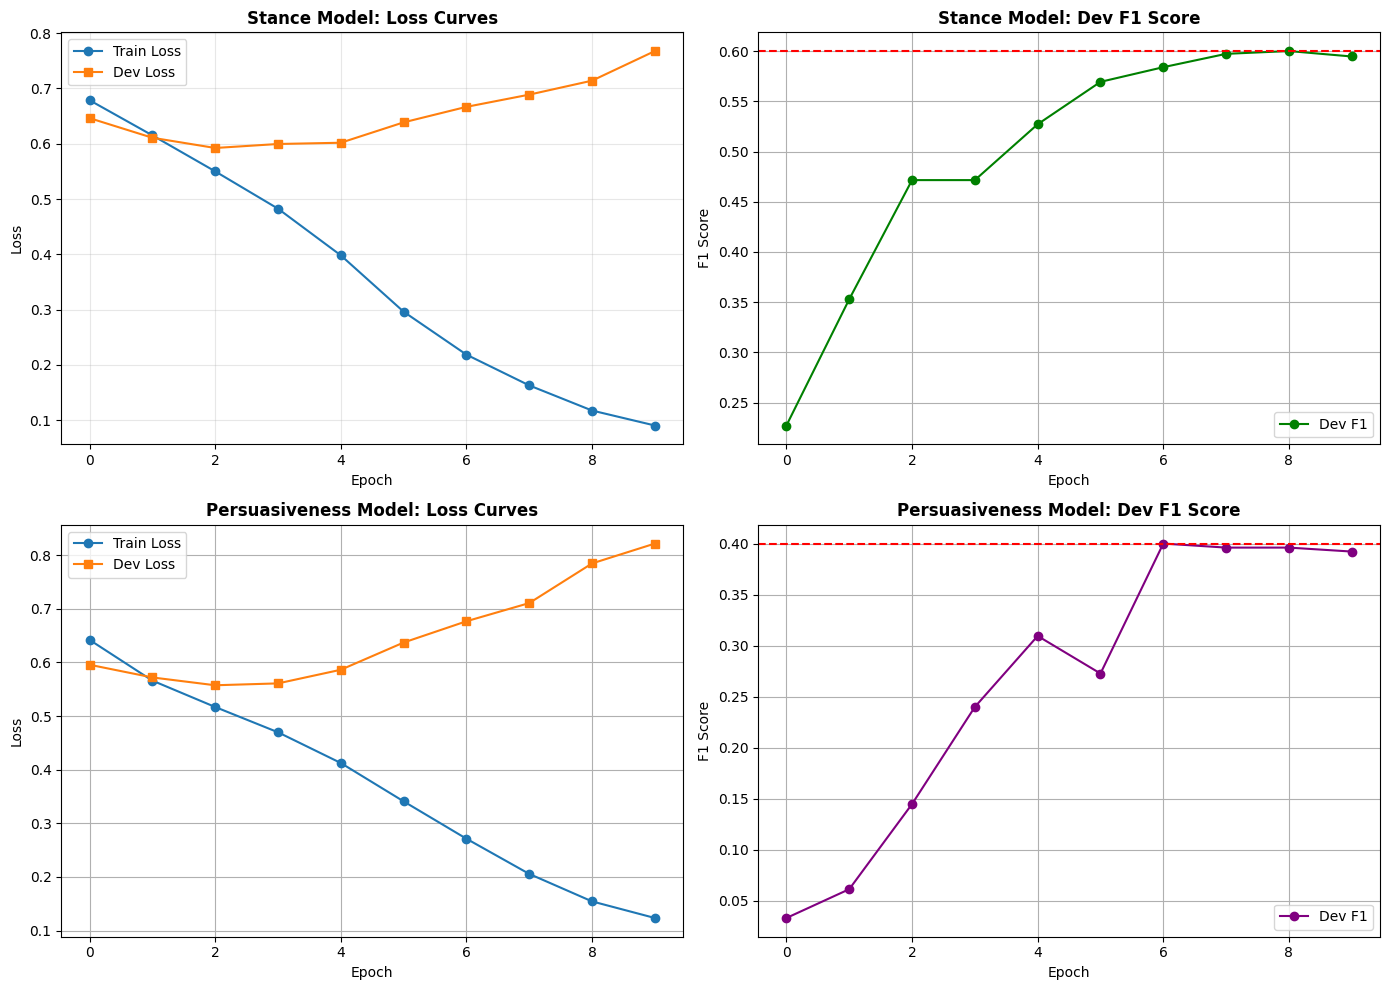

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Stance- training loss
axes[0, 0].plot(stance_history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(stance_history['dev_loss'], label='Dev Loss', marker='s')
axes[0, 0].set_title('Stance Model: Loss Curves', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Stance dev F1
axes[0, 1].plot(stance_history['dev_f1'], label='Dev F1', marker='o', color='green')
axes[0, 1].set_title('Stance Model: Dev F1 Score', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].legend()
axes[0, 1].grid(True)
axes[0, 1].axhline(y=max(stance_history['dev_f1']), color='r', linestyle='--', label=f'Best: {max(stance_history["dev_f1"]):.4f}')

# Persuasiveness training loss
axes[1, 0].plot(pers_history['train_loss'], label='Train Loss', marker='o')
axes[1, 0].plot(pers_history['dev_loss'], label='Dev Loss', marker='s')
axes[1, 0].set_title('Persuasiveness Model: Loss Curves', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Persuasiveness dev F1
axes[1, 1].plot(pers_history['dev_f1'], label='Dev F1', marker='o', color='purple')
axes[1, 1].set_title('Persuasiveness Model: Dev F1 Score', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].legend()
axes[1, 1].grid(True)
axes[1, 1].axhline(y=max(pers_history['dev_f1']), color='r', linestyle='--', label=f'Best: {max(pers_history["dev_f1"]):.4f}')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), bbox_inches='tight')
plt.show()


Since our architecture is based on a freezed RestNet50, the pretrained model learns very quickly, so the training loss keeps decreasing, so it begins to overfit early cuasing the dev loss to rise (Epoch >2).

However, the F1-score is still improving while the loss rises, because the F1 measures the correct class decisions and it is less sensitive to probabilities.

The models reach it's best performance in the Epoch 8 and 6 respectively.

### Confusion Matrices

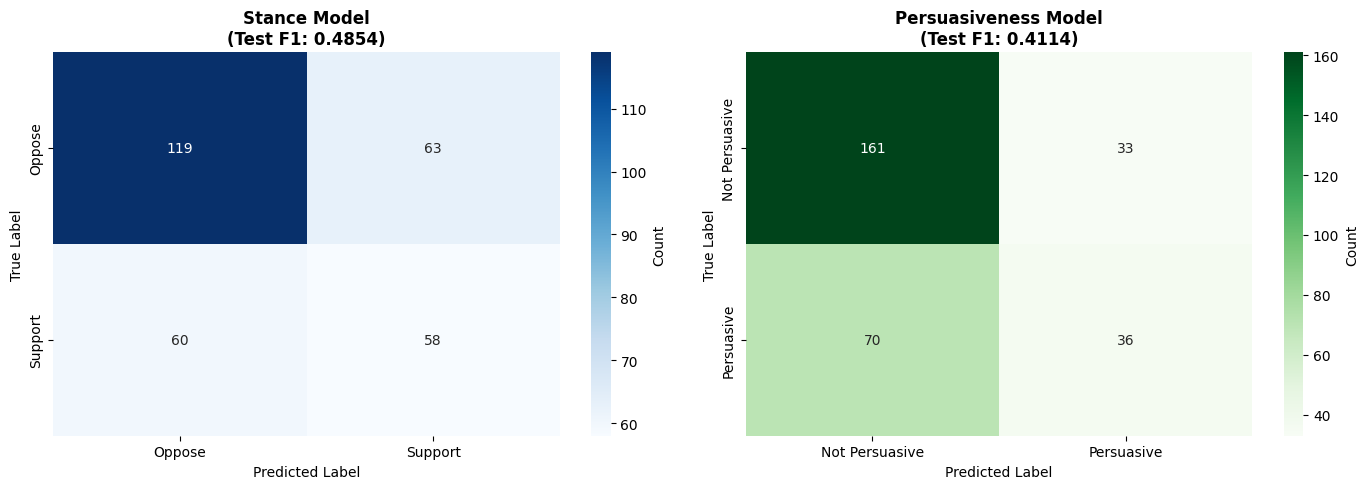

Confusion matrices saved to: ./baseline_outputs/confusion_matrices.png


In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stance confusion matrix
sns.heatmap(
    stance_test_results['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Oppose', 'Support'],
    yticklabels=['Oppose', 'Support'],
    ax=axes[0],
    cbar_kws={'label': 'Count'}
)
axes[0].set_title(f'Stance Model\n(Test F1: {stance_test_results["f1"]:.4f})', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Persuasiveness confusion matrix
sns.heatmap(
    pers_test_results['confusion_matrix'],
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=['Not Persuasive', 'Persuasive'],
    yticklabels=['Not Persuasive', 'Persuasive'],
    ax=axes[1],
    cbar_kws={'label': 'Count'}
)
axes[1].set_title(f'Persuasiveness Model\n(Test F1: {pers_test_results["f1"]:.4f})', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.png'), bbox_inches='tight')
plt.show()

print(f"Confusion matrices saved to: {OUTPUT_DIR}confusion_matrices.png")

As we expected, these confusion matrices and F1 scores show that the images alone by themselve do not serve for any binary classification tasks.

### Task Correlation Analysis

In [41]:
# Create results dataframe
results_df = pd.DataFrame({
    'stance_true': stance_test_results['y_true'],
    'stance_pred': stance_test_results['y_pred'],
    'pers_true': pers_test_results['y_true'],
    'pers_pred': pers_test_results['y_pred']
})

# We add auxiliary columns for correctness
results_df['stance_correct'] = (results_df['stance_true'] == results_df['stance_pred']).astype(int)
results_df['pers_correct'] = (results_df['pers_true'] == results_df['pers_pred']).astype(int)
results_df['both_correct'] = (results_df['stance_correct'] & results_df['pers_correct']).astype(int)

# Correlations 
print(f"Samples where BOTH are correct: {results_df['both_correct'].sum()} / {len(results_df)} ({results_df['both_correct'].mean()*100:.2f}%)")
print(f"Samples where ONLY stance correct: {((results_df['stance_correct']==1) & (results_df['pers_correct']==0)).sum()}")
print(f"Samples where ONLY persuasiveness correct: {((results_df['stance_correct']==0) & (results_df['pers_correct']==1)).sum()}")
print(f"Samples where BOTH are wrong: {((results_df['stance_correct']==0) & (results_df['pers_correct']==0)).sum()}")

# Pearson correlation between correctness
#When the model gets stance right, does it also tend to get persuasiveness right?
corr_coef, p_value = pearsonr(results_df['stance_correct'], results_df['pers_correct'])
print(f"\n  Pearson correlation (correctness): {corr_coef:.4f} (p-value: {p_value:.4e})")

# Correlation between true labels
# When the true stance is support, is it also more likely to be persuasive?
label_corr, label_p = pearsonr(results_df['stance_true'], results_df['pers_true'])
print(f"  Correlation between TRUE labels: {label_corr:.4f} (p-value: {label_p:.4e})")

# Do they correlate enough to build a multitask model?

Samples where BOTH are correct: 115 / 300 (38.33%)
Samples where ONLY stance correct: 62
Samples where ONLY persuasiveness correct: 82
Samples where BOTH are wrong: 41

  Pearson correlation (correctness): -0.0176 (p-value: 7.6201e-01)
  Correlation between TRUE labels: 0.0615 (p-value: 2.8850e-01)


Initial test suggests there is no strong correlation between tasks.